In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pipeline_file import DocumentationQA, EmbeddingManager, QdrantManager

In [3]:
df = pd.read_csv("texts_with_answers.csv")

In [ ]:
df.question.nunique()

# 109 уникальных вопросов

109

In [ ]:
df.name.nunique()

# 11 тематик: каждая соответствует конкретному блоку документации

11

In [ ]:
df.text.nunique()

# 11  уникальных текстов: 1 текст соответствует 1 тематике

11

Далее посмотрим на пример вывода трех фрагментов, ближайших по косинусному расстоянию задаваемому вопросу

In [15]:
def get_fragments_for_questions(questions_file_path):
    # Загрузка вопросов из CSV файла
    df = pd.read_csv(questions_file_path)
    
    # Инициализация компонентов
    qa_system = DocumentationQA()
    
    # Инициализация базы данных (скачивание и индексация документации)
    print("Инициализация базы документации...")
    qa_system.initialize_database()
    print("База документации инициализирована успешно!")
    
    # Создаем колонки для хранения результатов
    result_df = df.copy()
    for i in range(3):  # Три фрагмента
        result_df[f'fragment_{i+1}'] = ''
        result_df[f'doc_name_{i+1}'] = ''
        result_df[f'score_{i+1}'] = 0.0
    
    # Обработка каждого вопроса
    print(f"Обрабатываем {len(df)} вопросов...")
    for idx, row in df.iterrows():
        question = row['question']
        
        # Получение похожих фрагментов для вопроса
        similar_paragraphs = qa_system.search_similar_paragraphs(question, top_k=3)
        
        # Сохранение результатов
        for i, (text, doc_name, score) in enumerate(similar_paragraphs):
            if i < 3:  # Сохраняем только первые три результата
                result_df.loc[idx, f'fragment_{i+1}'] = text
                result_df.loc[idx, f'doc_name_{i+1}'] = doc_name
                result_df.loc[idx, f'score_{i+1}'] = score
    
    return result_df

def display_results(results, index=0):
    """
    Выводит информацию о вопросе, его фрагментах и косинусных расстояниях.
    :param results: DataFrame с результатами
    :param index: Индекс строки для отображения
    """
    if index >= len(results):
        print(f"Индекс {index} выходит за пределы данных.")
        return
    
    row = results.iloc[index]
    print("\n=== Результаты для вопроса ===")
    print(f"Вопрос: {row['question']}")
    
    for i in range(3):
        fragment = row[f'fragment_{i+1}']
        doc_name = row[f'doc_name_{i+1}']
        score = row[f'score_{i+1}']
        
        print(f"\nФрагмент {i+1}:")
        print(f"Документ: {doc_name}")
        print(f"Косинусное расстояние: {score:.4f}")
        print(f"Текст фрагмента:\n{fragment}\n")

if __name__ == "__main__":
    # Путь к файлу с вопросами
    questions_file = "texts_with_answers.csv"
    
    # Получение фрагментов для каждого вопроса
    results = get_fragments_for_questions(questions_file)
    
    # Вывод примера результатов для одного вопроса
    display_results(results, index=5)

Инициализация базы документации...
База документации инициализирована успешно!
Обрабатываем 120 вопросов...

=== Результаты для вопроса ===
Вопрос: What happens if different types of vectors are used within a collection?

Фрагмент 1:
Документ: vectors
Косинусное расстояние: 0.8479
Текст фрагмента:
Each vector should have a unique name. Vectors can represent different modalities and you can use different embedding models to generate them.


Фрагмент 2:
Документ: collections
Косинусное расстояние: 0.8448
Текст фрагмента:
If you insert the vectors into the collection, the field may become whilst it is optimizing. It will become once all the points are successfully processed. The following color statuses are possible:

🟢 : collection is ready 🟡 : collection is optimizing ⚫ : collection is pending optimization (help) 🔴 : an error occurred which the engine could not recover from


Фрагмент 3:
Документ: collections
Косинусное расстояние: 0.8408
Текст фрагмента:
Default parameters for the opti

Ок, дальше проанализируем, сколько фрагментов имеет смысл брать. Будем основываться на косинусном расстоянии, посмотрим основные метрики и сделаем выводы.
1. Возьмем для каждого вопроса первые по косиносному расстоянию 50 фрагментов
2. Посмотрим на распределения и меры среднего

In [31]:
def get_fragments_for_questions(questions_file_path):
    # Загрузка вопросов из CSV файла
    df = pd.read_csv(questions_file_path)
    
    # Инициализация компонентов
    qa_system = DocumentationQA()
    
    # Инициализация базы данных (скачивание и индексация документации)
    print("Инициализация базы документации...")
    qa_system.initialize_database()
    print("База документации инициализирована успешно!")
    
    # Создаем пустой датафрейм для хранения результатов
    columns = ['question', 'fragment', 'cosine_distance']
    results_df = pd.DataFrame(columns=columns)
    
    # Обработка каждого вопроса
    print(f"Обрабатываем {len(df)} вопросов...")
    for idx, row in df.iterrows():
        question = row['question']
        
        # Получение похожих фрагментов для вопроса
        similar_paragraphs = qa_system.search_similar_paragraphs(question, top_k=50)
        
        # Сохранение результатов в датафрейм
        for text, doc_name, score in similar_paragraphs:
            new_row = {
                'question': question,
                'fragment': text,
                'cosine_distance': score
            }
            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    return results_df

if __name__ == "__main__":
    # Путь к файлу с вопросами
    questions_file = "texts_with_answers.csv"
    
    # Получение фрагментов для каждого вопроса
    results = get_fragments_for_questions(questions_file)
    
    # Вывод примера результатов
    print("\nПример результатов:")
    print(results.head())

Инициализация базы документации...
База документации инициализирована успешно!
Обрабатываем 120 вопросов...


C:\Users\sekho\AppData\Local\Temp\ipykernel_21612\1687018382.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)



Пример результатов:
                                         question  \
0  What is a collection in the context of Qdrant?   
1  What is a collection in the context of Qdrant?   
2  What is a collection in the context of Qdrant?   
3  What is a collection in the context of Qdrant?   
4  What is a collection in the context of Qdrant?   

                                            fragment  cosine_distance  
0  title: Collections weight: 30 aliases: - ../co...         0.865962  
1  Qdrant counts this metric in 2 steps, due to w...         0.833325  
2  Grey collection status Available as of v1.9.0 ...         0.831412  
3  Available as of v1.1.1 For each named vector y...         0.829753  
4  Set up option for the vectors in the collectio...         0.828442  


In [34]:
results.shape

(6000, 3)

In [36]:
results.groupby('question', as_index=False).agg(
    mean_cosine=('cosine_distance', 'mean'),
    median_cosine=('cosine_distance', 'median'),
    variance_cosine=('cosine_distance', 'var')
)

,question,mean_cosine,median_cosine,variance_cosine
0,Can collections be updated after their creation?,0.777661,0.773043,0.000285
1,Can multiple types of vectors be attached to a...,0.839039,0.837730,0.000175
2,Can the Distance Matrix API be used for cluste...,0.831562,0.829453,0.000193
3,"Can you filter using nested fields in Qdrant, ...",0.828243,0.825386,0.000128
4,Can you perform a query using a point ID as an...,0.834999,0.834476,0.000183
...,...,...,...,...
104,Where are snapshots stored by default?,0.779226,0.772392,0.000405
105,Which method is used to remove all payload key...,0.810544,0.803674,0.000371
106,Which similarity search method is referred to ...,0.780082,0.775455,0.000294
107,Why is it more efficient to apply changes in b...,0.823368,0.820796,0.000098


Посмотрим, есть ли выбросы

In [37]:
results.groupby('question', as_index=False).agg(
    mean_cosine=('cosine_distance', 'mean'),
    median_cosine=('cosine_distance', 'median'),
    variance_cosine=('cosine_distance', 'var')
).query('mean_cosine != median_cosine')

,question,mean_cosine,median_cosine,variance_cosine
0,Can collections be updated after their creation?,0.777661,0.773043,0.000285
1,Can multiple types of vectors be attached to a...,0.839039,0.837730,0.000175
2,Can the Distance Matrix API be used for cluste...,0.831562,0.829453,0.000193
3,"Can you filter using nested fields in Qdrant, ...",0.828243,0.825386,0.000128
4,Can you perform a query using a point ID as an...,0.834999,0.834476,0.000183
...,...,...,...,...
104,Where are snapshots stored by default?,0.779226,0.772392,0.000405
105,Which method is used to remove all payload key...,0.810544,0.803674,0.000371
106,Which similarity search method is referred to ...,0.780082,0.775455,0.000294
107,Why is it more efficient to apply changes in b...,0.823368,0.820796,0.000098


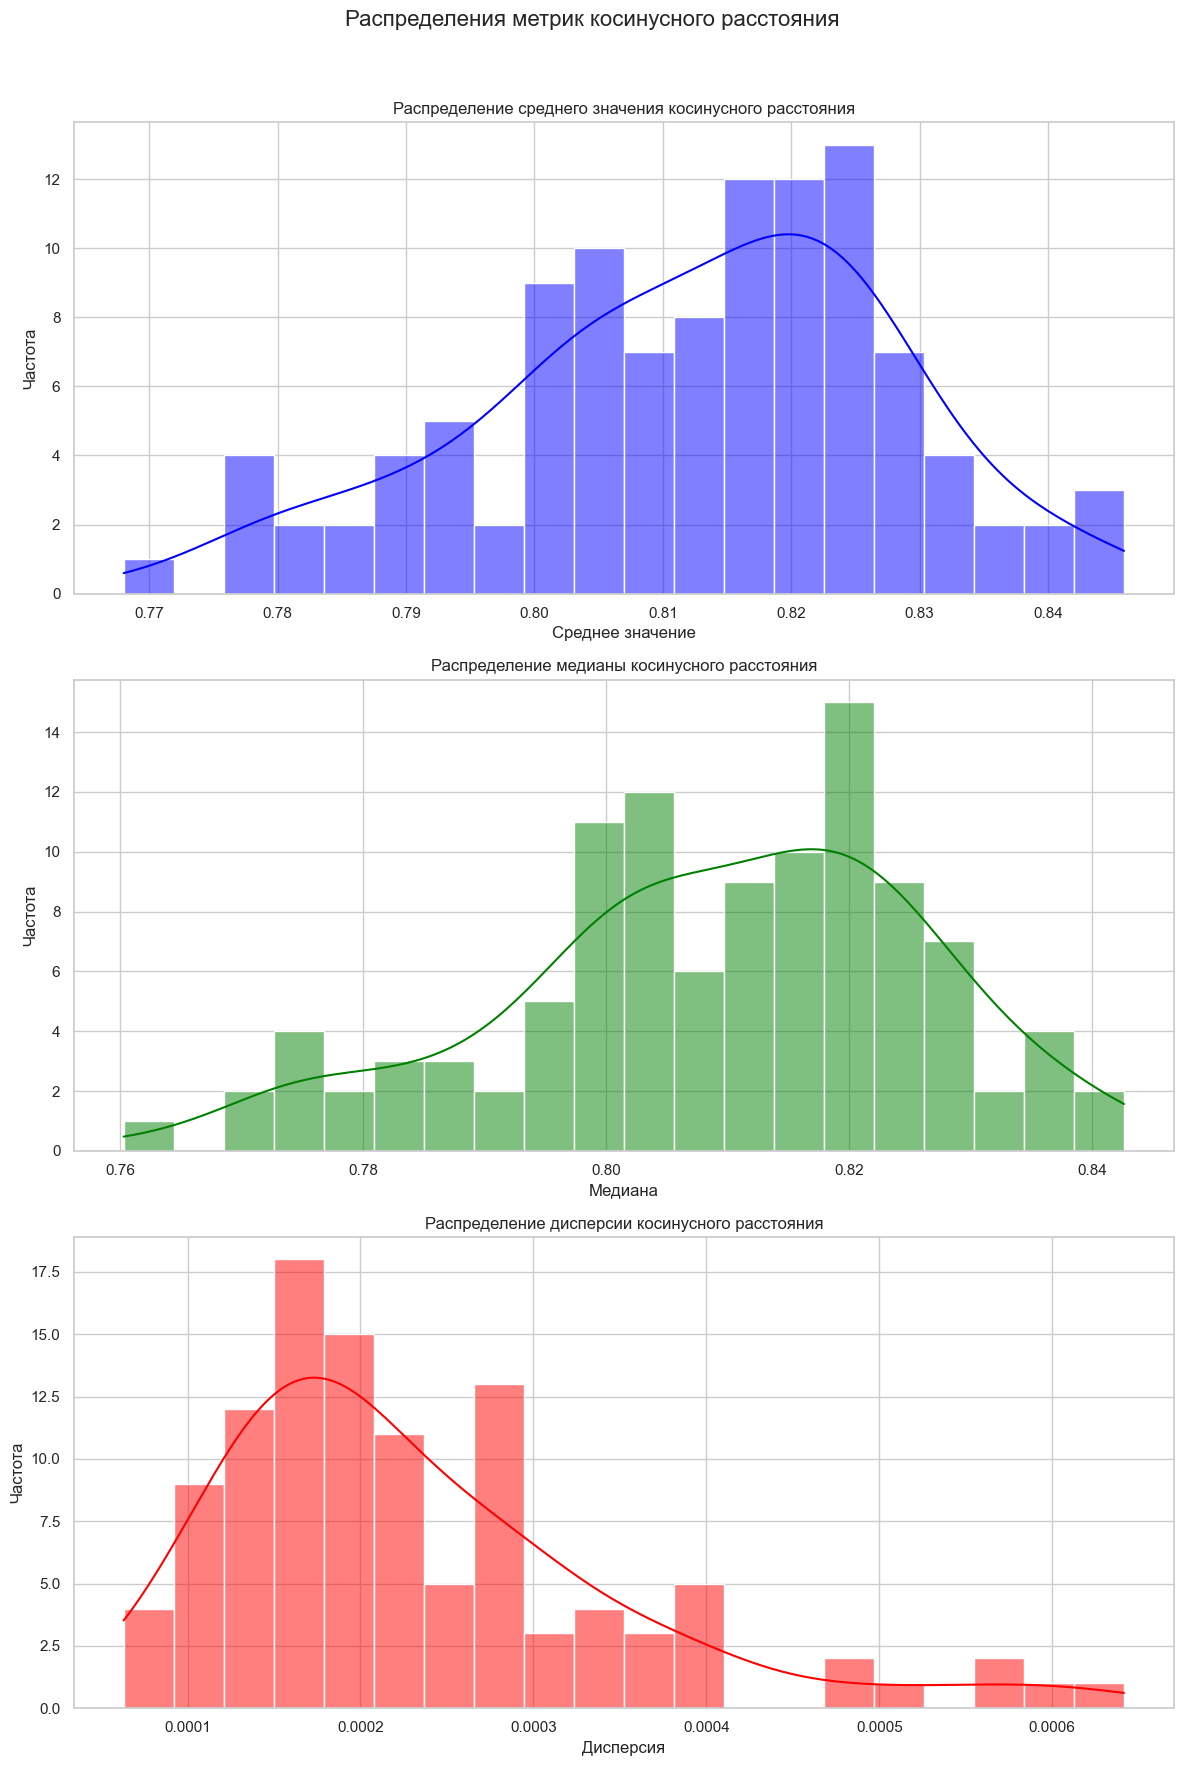

In [39]:
aggregated = results.groupby('question', as_index=False).agg(
    mean_cosine=('cosine_distance', 'mean'),
    median_cosine=('cosine_distance', 'median'),
    variance_cosine=('cosine_distance', 'var')
)

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание подграфиков
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # 3 графика (по одному на каждую метрику)

# График 1: Распределение среднего значения косинусного расстояния
sns.histplot(aggregated['mean_cosine'], kde=True, bins=20, ax=axes[0], color='blue')
axes[0].set_title('Распределение среднего значения косинусного расстояния')
axes[0].set_xlabel('Среднее значение')
axes[0].set_ylabel('Частота')

# График 2: Распределение медианы косинусного расстояния
sns.histplot(aggregated['median_cosine'], kde=True, bins=20, ax=axes[1], color='green')
axes[1].set_title('Распределение медианы косинусного расстояния')
axes[1].set_xlabel('Медиана')
axes[1].set_ylabel('Частота')

# График 3: Распределение дисперсии косинусного расстояния
sns.histplot(aggregated['variance_cosine'], kde=True, bins=20, ax=axes[2], color='red')
axes[2].set_title('Распределение дисперсии косинусного расстояния')
axes[2].set_xlabel('Дисперсия')
axes[2].set_ylabel('Частота')

# Общий заголовок
plt.suptitle('Распределения метрик косинусного расстояния', fontsize=16)

# Отображение графиков
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Оставляем место для общего заголовка
plt.show()

Графики медианы и среднего выглядят похоже, по дисперсии есть редкие выбросы. Попробуем следующее: посчитаем среднее, медиану, дисперсию для первых трех, 10, 25 и 50 фрагментов.

In [53]:
def calculate_metrics(results):
    # Создаем пустой датафрейм для хранения результатов
    metrics_df = pd.DataFrame()

    # Определяем количество фрагментов для анализа
    fragment_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]

    # Группируем данные по вопросам
    grouped = results.groupby('question')

    # Для каждого вопроса считаем метрики для первых N фрагментов
    for question, group in grouped:
        for n in fragment_counts:
            # Берем первые N фрагментов
            subset = group.head(n)

            # Вычисляем метрики
            mean_val = subset['cosine_distance'].mean()
            median_val = subset['cosine_distance'].median()
            variance_val = subset['cosine_distance'].var()

            # Добавляем результаты в датафрейм
            metrics_df = pd.concat([
                metrics_df,
                pd.DataFrame({
                    'question': [question],
                    'num_fragments': [n],
                    'mean_cosine': [mean_val],
                    'median_cosine': [median_val],
                    'variance_cosine': [variance_val]
                })
            ], ignore_index=True)

    return metrics_df

# Пример использования
if __name__ == "__main__":

    # Вычисляем метрики
    metrics = calculate_metrics(results)

    # Выводим результаты
    print("\nМетрики для каждого вопроса:")
    print(metrics)


Метрики для каждого вопроса:
                                               question  num_fragments  \
0      Can collections be updated after their creation?              2   
1      Can collections be updated after their creation?              3   
2      Can collections be updated after their creation?              4   
3      Can collections be updated after their creation?              5   
4      Can collections be updated after their creation?              6   
...                                                 ...            ...   
1521  Why might a user choose to disable indexing du...             15   
1522  Why might a user choose to disable indexing du...             20   
1523  Why might a user choose to disable indexing du...             30   
1524  Why might a user choose to disable indexing du...             40   
1525  Why might a user choose to disable indexing du...             50   

      mean_cosine  median_cosine  variance_cosine  
0        0.822219       0.822

In [54]:
metrics.groupby(['num_fragments'], as_index=False).agg({'mean_cosine':'mean', 'median_cosine':'mean', 'variance_cosine':'mean'})
# средняя дисперсия почти в два раза вырастает на 50 фрагментах по сравнению с 3
# медианное и среднее расстояние логично падают с увеличением числа фрагментов

,num_fragments,mean_cosine,median_cosine,variance_cosine
0,2,0.852444,0.852444,0.000131
1,3,0.848720,0.846331,0.000125
2,4,0.845885,0.843801,0.000125
3,5,0.843548,0.841272,0.000129
4,6,0.841565,0.839325,0.000132
5,7,0.839785,0.837379,0.000136
6,8,0.838217,0.835789,0.000140
7,9,0.836734,0.834200,0.000148
8,10,0.835384,0.832926,0.000154
9,15,0.830107,0.827236,0.000170


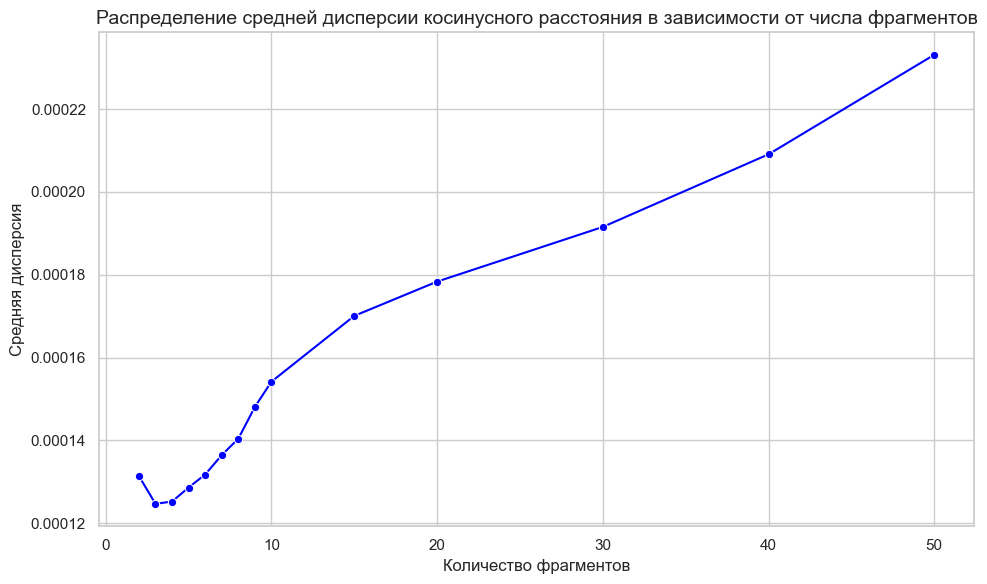

In [55]:
aggregated_metrics = metrics.groupby(['num_fragments'], as_index=False).agg({
    'mean_cosine': 'mean',
    'median_cosine': 'mean',
    'variance_cosine': 'mean'
})

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание графика для variance_cosine
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_metrics, x='num_fragments', y='variance_cosine', marker='o', color='blue')

# Настройка заголовков и подписей осей
plt.title('Распределение средней дисперсии косинусного расстояния в зависимости от числа фрагментов', fontsize=14)
plt.xlabel('Количество фрагментов', fontsize=12)
plt.ylabel('Средняя дисперсия', fontsize=12)

# Отображение графика
plt.tight_layout()
plt.show()

По графику вижу два варианта: 4 фрагмента и 6 фрагментов. Дальше разброс среднего косинусного расстояния значительно растет.